# Aprendendo como mexer no Wavelet

In [37]:
from __future__ import division
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd
from scipy import pi
from scipy.fftpack import fft

import pycwt as wavelet
from pycwt.helpers import find

In [38]:
dados = pd.read_excel('SN_m_tot.xlsx')
print(dados)

      Year  Month  Month in fraction of year  \
0     1749      1                   1749.042   
1     1749      2                   1749.123   
2     1749      3                   1749.204   
3     1749      4                   1749.288   
4     1749      5                   1749.371   
...    ...    ...                        ...   
3274  2021     11                   2021.873   
3275  2021     12                   2021.958   
3276  2022      1                   2022.042   
3277  2022      2                   2022.122   
3278  2022      3                   2022.204   

      Monthly mean total sunspot number  
0                                  96.7  
1                                 104.3  
2                                 116.7  
3                                  92.8  
4                                 141.7  
...                                 ...  
3274                               35.0  
3275                               67.6  
3276                               54.0  
327

In [39]:
# Formatando o índice
indice = []
for i in range(len(dados['Year'])):
    indice.append([dados['Year'][i], dados['Month'][i]])
indice = tuple(indice)
indice = pd.MultiIndex.from_tuples(indice, names=["Year", "Month"])

# Colocando em fracao de ano do jeito padrão
for _ in range(len(dados['Year'])):
    dados['Month in fraction of year'][_] = int(dados['Year'][_]) + int(dados['Month'][_])*1/12
indice_fraction =  dados['Month in fraction of year']
print(dados['Month in fraction of year'])

C:\Users\Morgan-PC\AppData\Local\Temp\ipykernel_6528\897554634.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Month in fraction of year'][_] = int(dados['Year'][_]) + int(dados['Month'][_])*1/12


0       1749.083333
1       1749.166667
2       1749.250000
3       1749.333333
4       1749.416667
           ...     
3274    2021.916667
3275    2022.000000
3276    2022.083333
3277    2022.166667
3278    2022.250000
Name: Month in fraction of year, Length: 3279, dtype: float64


                           Monthly mean total sunspot number
Month in fraction of year                                   
1749.083333                                             96.7
1749.166667                                            104.3
1749.250000                                            116.7
1749.333333                                             92.8
1749.416667                                            141.7
...                                                      ...
2021.916667                                             35.0
2022.000000                                             67.6
2022.083333                                             54.0
2022.166667                                             59.7
2022.250000                                             78.5

[3279 rows x 1 columns]


<AxesSubplot:title={'center':'Sunspot number per month'}, xlabel='Date (Year)', ylabel='Number of sunspot'>

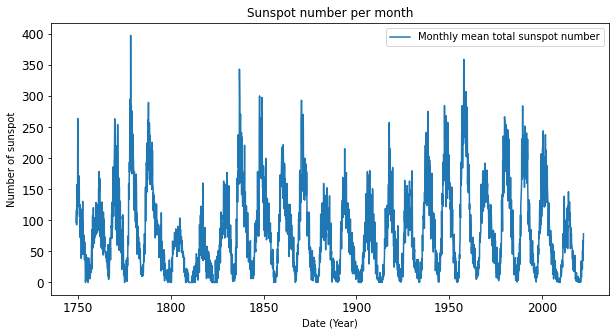

In [40]:
# Colocando os valores de Sunspot em uma tabelinha
valores = []
for i in dados['Monthly mean total sunspot number']:
    valores.append(i)
tabelinha = pd.DataFrame(valores, index=indice_fraction, columns=['Monthly mean total sunspot number'])
print(tabelinha)
tabelinha.plot(fontsize=12, figsize=(10, 5), title='Sunspot number per month', xlabel='Date (Year)', ylabel='Number of sunspot')

## Wavelet

In [41]:
dat = tabelinha['Monthly mean total sunspot number']

title = 'Número de SP medio por mês'
label = 'Números de SP medio'
units = 'Unidade'

t0 = 1749.083333 # Ano-Mês inicial
dt = (1)/(12) # Intervalos de 1 mês
N = dat.size
t = np.arange(0,N) * dt + t0

print(dat)


Month in fraction of year
1749.083333     96.7
1749.166667    104.3
1749.250000    116.7
1749.333333     92.8
1749.416667    141.7
               ...  
2021.916667     35.0
2022.000000     67.6
2022.083333     54.0
2022.166667     59.7
2022.250000     78.5
Name: Monthly mean total sunspot number, Length: 3279, dtype: float64


In [43]:
mother = wavelet.Morlet(6)
s0 = 1 * dt # Escala inicial
dj = 1 / 12  
J = 7 / dj 
valores = np.array(valores)
dat = np.array(dat)
alpha, _, _ = wavelet.ar1(valores)

In [44]:
# Aplica transformada
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J, mother)

In [45]:
# espectro de potencia
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = (1 / freqs) 
# retifica
power /= scales[:, None]

In [46]:
# teste de significancia do espectro de potencia
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

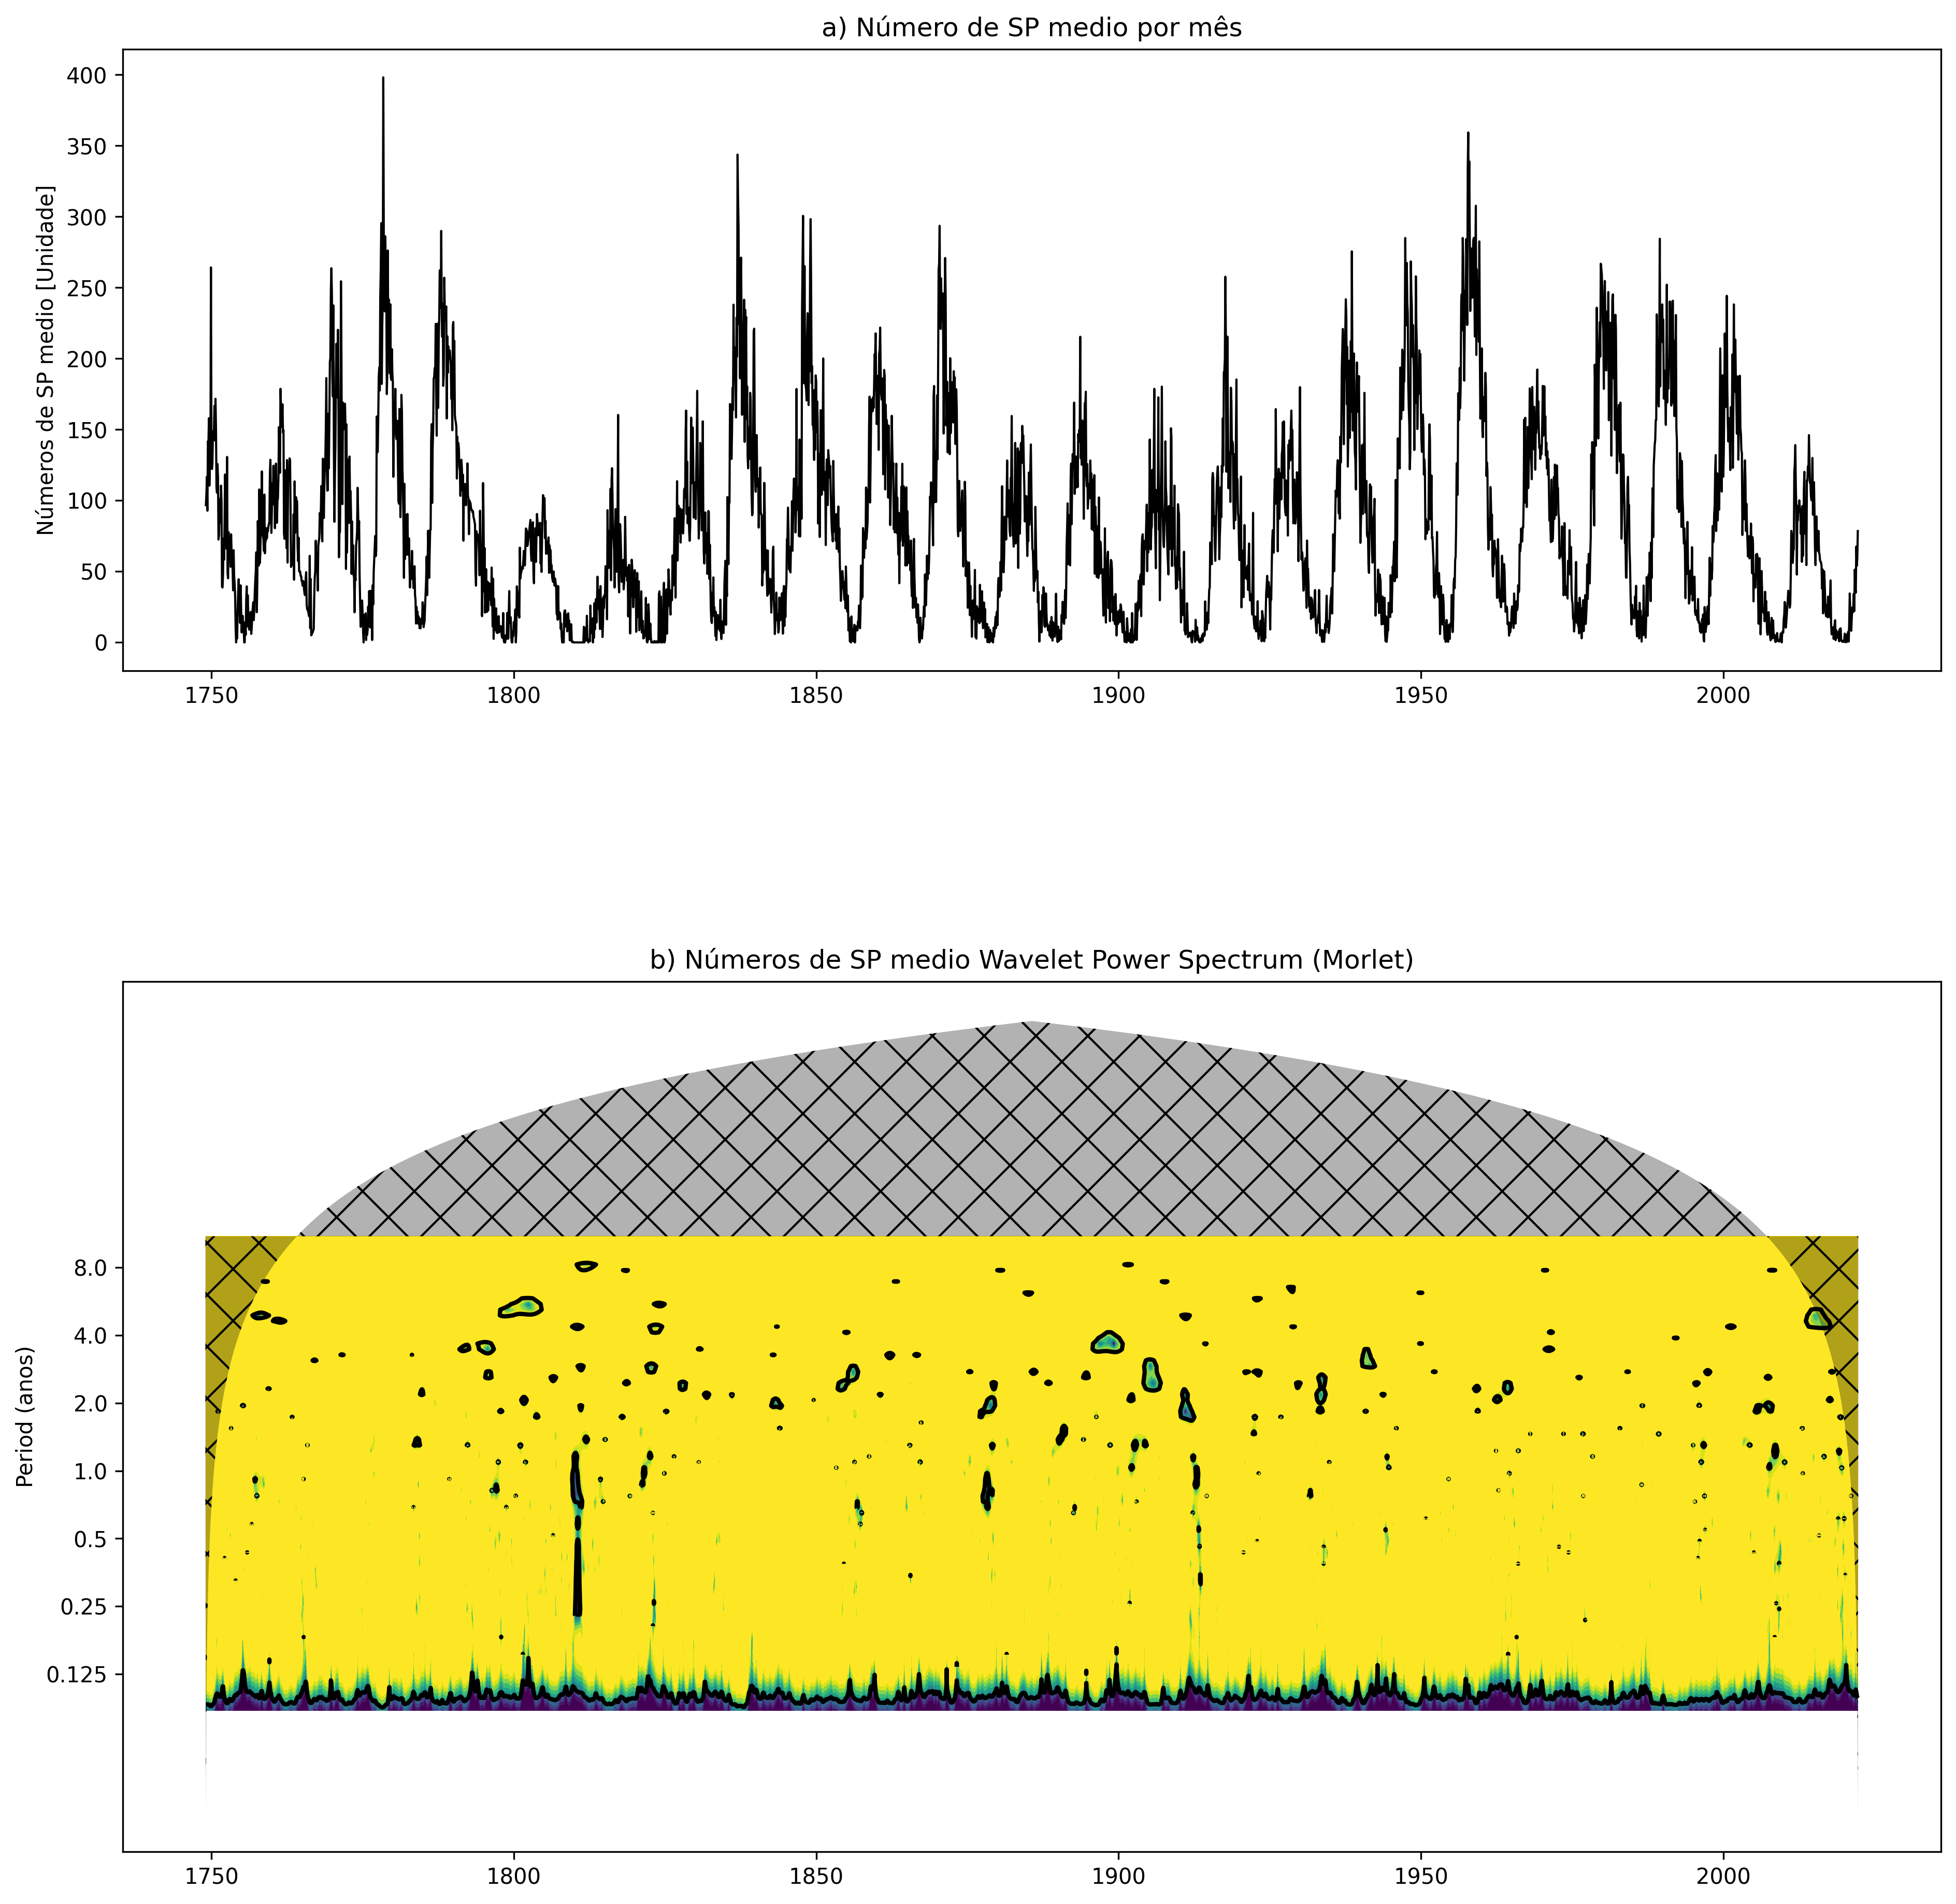

In [47]:
#figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(18, 20), dpi=300)
fig = pyplot.figure(**figprops)

#original timeseries
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, valores, 'k', linewidth=1.)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

#normalized wavelet power spectrum
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (anos)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


pyplot.show()